Generic velocity interpolator notebook for Antarctica

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pointCollection as pc
#%matplotlib widget
import time
import re
import h5py
import os
import glob
import pointAdvection 
import h5py
%load_ext autoreload 
%autoreload 2

import json
import datetime
import re
import argparse

In [2]:
# make a vel_source json file

vel_dir='/Volumes/ice1/ben/MEaSUREs/NSIDC-0720.001'
vel_re=re.compile('Antarctica_ice_velocity_(\d+)_(\d+)_1km')
t_file={np.mean([*map(float, vel_re.search(file).groups())]):file for file in sorted(glob.glob(f'{vel_dir}/*.nc'))}
vel_source=[{'time':year,'file':file, 'format':'NSIDC-0720'} for year, file in t_file.items()]
vel_source += [{'time':'mean', 'file':'/Volumes/ice3/tyler/MEaSUREs/NSIDC-0484.002/antarctica_ice_velocity_450m_v2.nc', 'format':'NSIDC-0484'}]
with open('Measures_AA_vel_maps.json','w') as fh:
    json.dump(vel_source, fh)

In [3]:
# sample input arguments:

args=argparse.Namespace(
    xy0 = [-0.2e6, -0.5e6],
    W = 2.e5,
    t_range = [2018, 2024],
    velocity_time_range=None,
    velocity_source_file='./Measures_AA_vel_maps.json',
    res=5.e2, 
    lagrangian_epoch=2022,
    epsg=3031,
    t_step=0.25,
    speed_est=1.e3, 
    save_base='./xy0_interpolators',
    interpolator_save_file=None)

if args.interpolator_save_file is not None:
    interpolator_save_file=args.interpolator_save_file
else:
    interpolator_save_file=f'{args.save_base}_{args.t_range[0]}_{args.lagrangian_epoch}_{args.t_range[1]}.h5'
print(interpolator_save_file)


./xy0_interpolators_2018_2022_2024.h5


In [4]:
bds = [jj + np.array([-1, 1])*args.W*0.5 for jj in args.xy0]

# pad the 
pad=args.speed_est*np.diff(args.t_range)*np.array([-1, 1])
bds_pad = [jj+pad for jj in bds]

with open(args.velocity_source_file,'r') as fh:
    vel_files=json.load(fh)
vel_files

t_file=[]
times = [vi['time'] for vi in vel_files if not isinstance(vi['time'],str)]
if args.velocity_time_range is not None:
    times= [tt for tt in times if (tt >= args.velocity_time_range[0]) and (tt <= args.velocity_time_range[1])]
    

time_order = np.argsort(times)

In [5]:
# make a list of advection objects, one for each velocity file
advs=[]
xg, yg = np.meshgrid(*[np.arange(bdsi[0], bdsi[1], args.res) for bdsi in bds])

for ind in time_order:
    temp=pointAdvection.velocity().from_file(vel_files[ind]['file'], format=vel_files[ind]['format'],  bounds=bds_pad)
    if temp.time is None:
        if temp.t is not None:
            temp.time=temp.t
        else:
            temp.time=vel_files[ind]['time']
    adv_i=pointAdvection.advection()
    adv_i.x=xg
    adv_i.y=yg
    adv_i.t=times[ind]
    adv_i.velocity=temp
    advs += [adv_i]



In [6]:
# put together the individual advection objects:
adv=pointAdvection.advection()
adv.x=xg
adv.y=yg

adv.from_list(advs)


In [7]:

# check if there is a 'mean' velocity file

for vi in vel_files:
    if vi['time']=='mean':
      adv.vel_mean=pointAdvection.velocity().from_file(vi['file'], format=vi['format'], bounds=bds_pad)\
        .interp_to(adv.velocity.x, adv.velocity.y)
if adv.vel_mean is None:
    adv.vel_mean=adv.calc_vel_mean(w_smooth=5)

# fill velocity gaps
adv.fill_velocity_gaps(annual=False, vel_mean=adv.vel_mean)


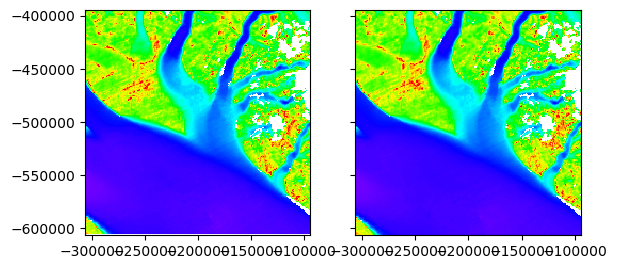

In [8]:

# check that the mean velocity looks like the mean of velocities
hf, hax=plt.subplots(1,2, sharex=True, sharey=True)
v0= adv.vel_mean.copy()
v0.assign(log_V=np.log10(np.abs(v0.U+1j*v0.V)))
v0.show(field='log_V', clim=[0, 3.5], cmap='hsv', ax=hax[0])
vv0=adv.calc_vel_mean()
vv0.assign(log_V=np.log10(np.abs(vv0.U+1j*vv0.V)))
vv0.show(field='log_V', clim=[0, 3.5], cmap='hsv', ax=hax[1])

In [9]:

# make the advection interpolators

t_vel = adv.velocity.time.copy()
adv.velocity.time = t_vel- args.lagrangian_epoch
blocksize=100    
bounds=adv.velocity.bounds()
# create an xy0 interpolator to find final locations for each point.
xy1 = adv.xy1_interpolator(bounds=bounds,
                               t_range=(np.array(args.t_range)-args.lagrangian_epoch),
                               t_step=args.t_step, advection_time_step=1/12, blocksize=blocksize)
# create an xy0 interpolator to find final locations for each point
xy0=adv.xy0_interpolator(bounds=bounds,
                           t_range=(np.array(args.t_range)-args.lagrangian_epoch),
                           t_step=args.t_step, advection_time_step=1/12, blocksize=50)
if os.path.isfile(interpolator_save_file):
    os.remove(interpolator_save_file)
xy1.to_h5(interpolator_save_file, group='xy1', replace=True)
xy0.to_h5(interpolator_save_file, group='xy0', replace=False)
with h5py.File(interpolator_save_file,'r+') as h5f:
    for group in ['xy0','xy1']:
        h5f[group].attrs['lagrangian_epoch']=args.lagrangian_epoch
        h5f[group]['t'].attrs['units']='years'


[(213,), (213,)]


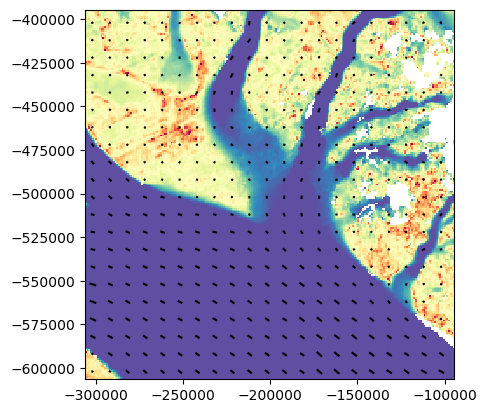

In [15]:
plt.figure()
vv0.show(field='log_V', cmap='Spectral', clim=[-0.3, 2])
for row in range(5, xy0.shape[1], 10):
    for col  in range(5, xy0.shape[0], 10):
        plt.plot(xy0.x0[row, col, :], xy0.y0[row, col, :],'k')